In [175]:
import pandas as pd
import os
import time
from datetime import datetime
import pytz
import asyncio
import numpy as np
import yfinance
from cvxpy import *
import numpy_ext as npext
import matplotlib.pyplot as plt
import statsmodels.api as sm
import json
from dateutil import parser
ROOT_DIR = os.path.dirname(os.path.abspath("wef.ipynb"))
ROOT_DIR


'/Users/yonas/Documents/Git/quant'

In [110]:
class PredModel () :
    def __init__ ( self , scaling_params , y_params , coeffs , regressors ) :
        self.scaling_params = scaling_params
        self.coeffs = coeffs
        self.y_params = y_params
        self.regressors = regressors

    def get_coeffs ( self ) :
        return self.coeffs

    def get_regressors ( self ) :
        return self.regressors

    def get_mapped_coefficients ( self ) :
        return { ticker : coeff for ticker , coeff in zip( self.get_regressors () , self.get_coeffs () ) }

    def pred ( self , sample ) :
        sample -= np.array ([ pair [0] for pair in self.scaling_params ])
        sample /= np.array ([ pair [1] for pair in self.scaling_params ])
        yhat = np.dot ( sample , self.coeffs )
        yhat = yhat * ( self.y_params [1] - self.y_params [0]) + self.y_params [0]
        return yhat

In [3]:

def mas_sneer_fomatter (filename,sheet ) :
    df = pd . read_excel ( f"{ filename }",sheet_name=sheet, header = None )
    df.columns = ["datetime", "sneer"]
    last_year , last_month = None , None
    for idx , row in df . iterrows () :
        unformatted = str( row ["datetime"]).strip () . split (" ")
        if unformatted[0]=='nan':
            continue
        #print(unformatted)
        if len( unformatted ) == 3:
            last_year = int( unformatted [0])
            last_month = time.strptime(unformatted [1] , '%b').tm_mon
            year = last_year
            month = last_month
            day = int ( unformatted [2])
            df.loc[ idx , "datetime"] = datetime( year , month , day , tzinfo = pytz.utc )
        if len( unformatted ) == 2:
            year = last_year
            last_month = time.strptime ( unformatted [0] , '%b').tm_mon
            month = last_month
            day = int ( unformatted [1])
            df.loc[ idx , "datetime"] = datetime( year , month , day , tzinfo = pytz.utc )
        if len( unformatted ) == 1:
            year = last_year
            month = last_month
            day = int ( unformatted [0])
            df.loc[ idx , "datetime"] = datetime( year , month , day , tzinfo = pytz.utc )  
    return df[pd.to_numeric(df.sneer, errors='coerce').notnull()]


sneer_df = pd.DataFrame()
for i in range (1999 , 2022 , 2) :
    print(i)
    datapath ="/Users/yonas/Documents/Git/quant/S$NEER_202301.xlsx"
    period_df = mas_sneer_fomatter( f"{ datapath }",str(i)+'-'+str(i+1)).set_index("datetime")
    sneer_df = pd.concat([sneer_df,period_df])

1999
2001
2003
2005
2007
2009
2011
2013
2015
2017
2019
2021


In [191]:

fx_currency = 'AAPL'


yfinance.Ticker(fx_currency + "").history(
start=daily_range[0],
end=daily_range[-1],
interval='1wk'
)



,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-01-04 00:00:00-05:00,0.321559,0.356760,0.320608,0.342490,2107851200,0.0,0.0
1999-01-11 00:00:00-05:00,0.348197,0.360089,0.304435,0.314425,5159392000,0.0,0.0
1999-01-18 00:00:00-05:00,0.319181,0.322035,0.282078,0.294921,2259264000,0.0,0.0
1999-01-25 00:00:00-05:00,0.298726,0.316327,0.295397,0.313473,1889328000,0.0,0.0
1999-02-01 00:00:00-05:00,0.317279,0.319181,0.270186,0.276370,2165800000,0.0,0.0
...,...,...,...,...,...,...,...
2022-11-28 00:00:00-05:00,145.139999,149.130005,140.350006,147.809998,401088500,0.0,0.0
2022-12-05 00:00:00-05:00,147.770004,150.919998,140.000000,142.160004,341500000,0.0,0.0
2022-12-12 00:00:00-05:00,142.699997,149.970001,133.729996,134.509995,505728900,0.0,0.0


In [77]:
def load_data ( daily_range) :
    '''SNEER CONSTITUENTS''' 
    tickers = ["SGDCNY", "USDSGD", "EURSGD", "TWDSGD", "SGDJPY", "SGDINR", "GBPSGD", "CHFSGD","USDPHP","USDTHB",'USDMYR']
    #fx_datas = await asyncio . gather (*[asyncio.create_task (_get_ticker_ohlcv ( fx_service , ticker , MSNEER . sneer_start - timedelta (days =7) , MSNEER . sneer_end )) for ticker in tickers ])

    # usdsgd = await _get_ticker_ohlcv ( fx_service , " USDSGD ", MSNEER.sneer_start -timedelta ( days =7) , MSNEER.sneer_end )
    # usdphp = await _get_ticker_ohlcv ( fx_service , " USDPHP ", MSNEER.sneer_start -timedelta ( days =7) , MSNEER.sneer_end )
    # usdmyr = await _get_ticker_ohlcv ( fx_service , " USDMYR ", MSNEER.sneer_start -timedelta ( days =7) , MSNEER.sneer_end )
    # usdthb = await _get_ticker_ohlcv ( fx_service , " USDTHB ", MSNEER.sneer_start -timedelta ( days =7) , MSNEER.sneer_end )
    # sgdphp = ( usdphp . set_index (" datetime ") / usdsgd . set_index (" datetime ") ) .reset_index ()
    # sgdmyr = ( usdmyr . set_index (" datetime ") / usdsgd . set_index (" datetime ") ) .reset_index ()
    # sgdthb = ( usdthb . set_index (" datetime ") / usdsgd . set_index (" datetime ") ) .reset_index ()
    
    # extras = [" SGDPHP ", " SGDMYR ", " THBSGD "]
    # extra_datas = [ sgdphp , sgdmyr , sgdthb ]
    # tickers . extend ( extras )
    # fx_datas . extend ( extra_datas )
    fx_datas = {}
    for i in tickers:
        data = yfinance.Ticker(i + "=X").history(start=daily_range[0],end=daily_range[-1],interval='1wk')
        fx_datas[i]=data.drop(['Open','High','Low','Volume','Dividends','Stock Splits'],axis=1)
    return fx_datas

daily_range = pd.date_range (
start = sneer_df.index . values [0] ,
end = sneer_df.index . values [ -1] ,
freq ="D",
tz = pytz.utc
)
fx_datas = load_data(daily_range)


In [140]:
def get_SGD_cross(data1, data2):
    df_trans = data1.join(data2,on='Date',how='inner',lsuffix='_l',rsuffix='_r')
    df_trans['Close']=df_trans['Close_r']/df_trans['Close_l']
    return df_trans.drop(['Close_r','Close_l'],axis=1)

def build_constituent_df(fx_datas,daily_range,sneer_df):
    fx_datas_clean ={}
    for i in fx_datas.keys():
        if (i[0:3]=='SGD')| any(i in x for x in ['USDPHP','USDMYR','USDTHB']) :
            continue
        df_trans = fx_datas[i].copy()
        df_trans['Close']=1/df_trans['Close']
        fx_datas_clean[i[3:6]+i[0:3]]=df_trans
    fx_datas_clean['SGDMYR']= get_SGD_cross(fx_datas['USDSGD'],fx_datas['USDMYR'])
    fx_datas_clean['SGDPHP']= get_SGD_cross(fx_datas['USDSGD'],fx_datas['USDPHP'])
    fx_datas_clean['SGDTHB']= get_SGD_cross(fx_datas['USDSGD'],fx_datas['USDTHB'])
    sneer_filled =pd.DataFrame(index=daily_range).join(sneer_df).fillna(method="ffill")
    sneer_filled.index =sneer_filled.index.date

    for i in fx_datas_clean.keys():
        test = fx_datas_clean[i].copy()
        test.index = test.index.date
        sneer_filled = sneer_filled.join(test, how='inner').rename(columns={'Close': i})
    return sneer_filled, fx_datas_clean.keys()


In [79]:
fx_datas.keys()
fx_datas_clean ={}
for i in fx_datas.keys():
    if (i[0:3]=='SGD')| any(i in x for x in ['USDPHP','USDMYR','USDTHB']) :
        continue
    df_trans = fx_datas[i].copy()
    df_trans['Close']=1/df_trans['Close']
    fx_datas_clean[i[3:6]+i[0:3]]=df_trans
fx_datas_clean['SGDMYR']= get_SGD_cross(fx_datas['USDSGD'],fx_datas['USDMYR'])
fx_datas_clean['SGDPHP']= get_SGD_cross(fx_datas['USDSGD'],fx_datas['USDPHP'])
fx_datas_clean['SGDTHB']= get_SGD_cross(fx_datas['USDSGD'],fx_datas['USDTHB'])
fx_datas_clean.keys()

dict_keys(['SGDUSD', 'SGDEUR', 'SGDTWD', 'SGDGBP', 'SGDCHF', 'SGDMYR', 'SGDPHP', 'SGDTHB'])

In [103]:
sneer_filled =pd.DataFrame(index=daily_range).join(sneer_df).fillna(method="ffill")
sneer_filled.index =sneer_filled.index.date

for i in fx_datas_clean.keys():
    test = fx_datas_clean[i].copy()
    test.index = test.index.date
    sneer_filled = sneer_filled.join(test, how='inner').rename(columns={'Close': i})
sneer_filled

,sneer,SGDUSD,SGDEUR,SGDTWD,SGDGBP,SGDCHF,SGDMYR,SGDPHP,SGDTHB
2003-12-01,97.31,0.583431,0.479685,19.747236,0.337610,0.744269,2.213711,32.100351,23.219370
2003-12-08,97.25,0.584693,0.479042,19.964065,0.335683,0.744269,2.239666,32.245806,23.231598
2003-12-15,97.36,0.585823,0.473889,20.020020,0.332082,0.736106,2.229350,32.290567,23.221441
2003-12-22,97.46,0.586682,0.472367,19.920319,0.330961,0.735781,2.227046,32.408333,23.222647
2003-12-29,97.46,0.587717,0.466941,19.984013,0.327697,0.728597,2.224978,32.494857,23.231266
...,...,...,...,...,...,...,...,...,...
2022-11-28,134.97,0.739754,0.702149,22.577441,0.602083,0.693780,3.243823,41.148840,25.660601
2022-12-05,135.02,0.737735,0.700133,22.654161,0.603318,0.689513,3.246772,40.722982,25.555146
2022-12-12,135.00,0.736160,0.696330,22.634677,0.606281,0.685824,3.255300,40.772231,23.791962
2022-12-19,134.91,0.740247,0.694059,22.744330,0.614062,0.690655,3.273373,40.726180,25.730992


In [114]:
df=sneer_filled
regressors = fx_datas_clean.keys()

In [113]:


def regression_analysis ( regressors , df ) :
    def rolling_model ( sneer , * cols ) :
        scaled_xs = []
        scaling_params = []
        for col in cols :
            zcol = ( col - np . mean ( col ) ) / np . std ( col )
            scaled_xs . append ( zcol )
            scaling_params . append (( np . mean ( col ) , np . std ( col ) ) )

        m = np . vstack ( scaled_xs )
        y = ( sneer - np .min( sneer ) ) / ( np .max( sneer ) - np .min( sneer ) )
        y_params = ( np .min( sneer ) , np .max( sneer ) )

        X = Variable ( m . shape [0])
        constraints = [ X >= 0 , sum( X ) == 1.0]
        product = m . T@diag ( X )
        diff = sum( product , axis =1) - y
        problem = Problem ( Minimize ( norm ( diff ) ) , constraints )
        problem . solve ( verbose = False )
        coeffs = X . value
        return PredModel ( scaling_params , y_params , coeffs , regressors )

    roll_datapoints = 52 * 3
    models = npext . rolling_apply (rolling_model ,roll_datapoints ,df["sneer"].values ,* df[regressors].transpose().values)

    predictions = pd . DataFrame ()
    predictions ["y"] = df ["sneer"]. reset_index ( drop = True )
    for idx , row in df [ regressors ]. reset_index ( drop = True ) . iterrows () :
        if idx == 0 or not isinstance ( models [ idx - 1] , PredModel ) :
            continue
        yhat = models [ idx - 1]. pred ( row . values )
        predictions . at [ idx , "yhat"] = yhat

    predictions . index = df . index
    predictions ["bias"] = predictions ["y"] - predictions ["yhat"]
    predictions ["yhathat"] = predictions ["yhat"] + predictions ["bias"]. shift (1)
    return predictions , models , df.index

sample_predictions , models , model_dates = regression_analysis( regressors =regressors , df = df )

In [115]:


predictions = pd.DataFrame ()
predictions["y"] = df["sneer"].reset_index(drop = True)
for idx , row in df[ regressors ].reset_index(drop = True ) . iterrows () :
    if idx == 0 or not isinstance( models[ idx - 1] , PredModel) :
        continue
    yhat = models[ idx - 1]. pred (row.values )
    predictions.at[ idx , "yhat"] = yhat

predictions.index = df.index
predictions["bias"] = predictions ["y"] - predictions ["yhat"]
predictions["yhathat"] = predictions["yhat"] + predictions["bias"].shift(1)

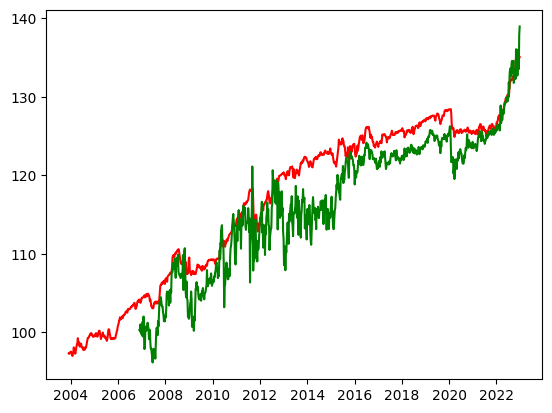

In [117]:
plt.plot(predictions.index, predictions['y'], color='red')
plt.plot(predictions.index, predictions['yhat'], color='green')
plt.show()

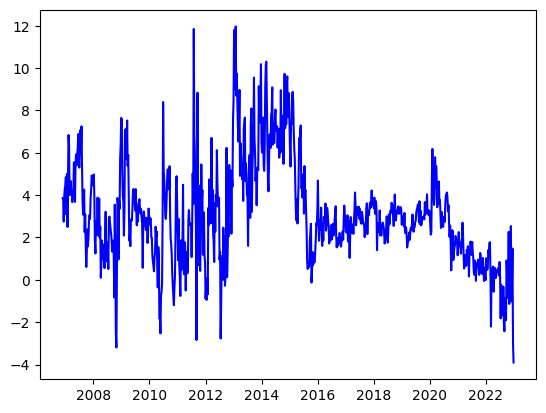

In [118]:
plt.plot(predictions.index, predictions['bias'], color='blue')
plt.show()

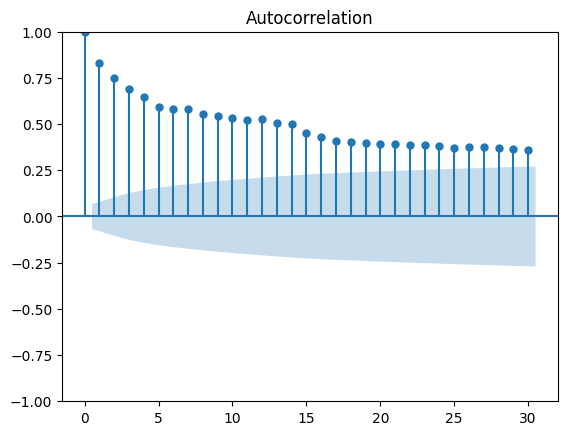

In [136]:
sm.graphics.tsa.plot_acf(predictions['bias'].dropna().values.squeeze(),lags=30)
plt.show()

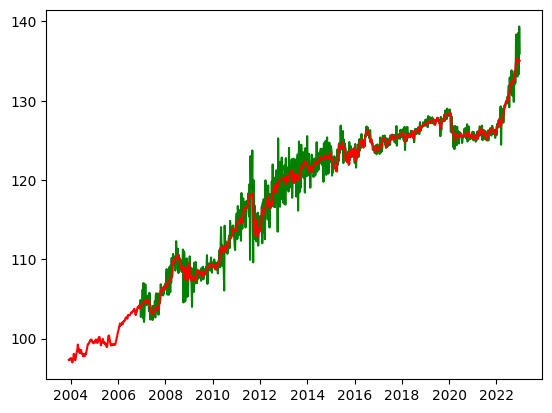

In [138]:
plt.plot(predictions.index, predictions['yhathat'], color='green')
plt.plot(predictions.index, predictions['y'], color='red')

plt.show()

In [146]:
def get_continuous_predictions(daily_range, fx_datas, models, model_dates, sneer_df ) :
    df , regressors = build_constituent_df(fx_datas,daily_range,sneer_df)
    
    j = 0
    while not isinstance( models[ j ] , PredModel ) :
        j += 1

    weights = {}
    for datetime , row in df[regressors].iterrows () :
        if datetime <= model_dates[ j ]:
            continue
        if ( j + 1) < len( model_dates ) and datetime > model_dates [ j + 1]:
            j += 1
        predmodel = models[ j ]
        yhat = predmodel.pred( row.values )
        df.at[ datetime , "yhat"] = yhat
        weights[ datetime ] = predmodel.get_mapped_coefficients ()
    
    df ["yhathat"] = df ["yhat"] + ( df["sneer"] - df ["yhat"]).shift(1)
    
    return df[['SGDUSD', 'SGDEUR', 'SGDTWD', 'SGDGBP', 'SGDCHF', 'SGDMYR',
       'SGDPHP', 'SGDTHB', 'yhat','sneer', 'yhathat']] , weights

continuous_predictions , weights = get_continuous_predictions(daily_range = daily_range , 
                                                                fx_datas = fx_datas , 
                                                                models = models ,
                                                                model_dates = model_dates ,
                                                                sneer_df=sneer_df)

In [176]:
def load_policies ( daily_range ) :
    with open ( f"{ ROOT_DIR }/sneer_pol.json", "r") as f :
        policies = json.load ( f )

    policy_df = pd . DataFrame ( policies ) . transpose () . reset_index () . rename ( columns ={"index" : "datetime"})
    policy_df ["datetime"] = policy_df ["datetime"]. apply ( lambda x : parser.parse ( x ) ). dt . tz_localize ( pytz . utc )

    df = pd . DataFrame ( index = pd . date_range ( start = policy_df ["datetime"]. values [0] ,end = daily_range . values [ -1] , tz = pytz . utc ) )
    policy_df = df . join ( policy_df . set_index ("datetime") )
    policy_df [["slope", "halfband"]] = policy_df [["slope", "halfband"]]. fillna (method ="ffill")
    policy_df = policy_df . reset_index ()
    for idx , row in policy_df . iterrows () :
        inc_py = row ["slope"]
        inc_pd = (1 + inc_py ) **(1/365) - 1
        scalar = 1 + inc_pd
        if pd . isna ( row ["mid"]) :
            mid = policy_df . at [ idx -1 , "mid"] * scalar
            policy_df . at [ idx , "mid"] = mid
    policy_df ["up"] = policy_df ["mid"] * (1 + policy_df ["halfband"])
    policy_df ["down"] = policy_df ["mid"] * (1 - policy_df ["halfband"])
    policy_df = policy_df . rename ( columns ={"index" : "datetime"}) . set_index ("datetime")
    return policy_df

In [182]:
policy_df = load_policies ( daily_range = daily_range )
policy_df ["real"] = sneer_df ["sneer"]
policy_df ["real"] = policy_df ["real"].fillna(method ="ffill")
policy_df.index=policy_df.index.date
policy_df ["pred"] = continuous_predictions["yhathat"]
policy_df ["pred"] = policy_df ["pred"].fillna(method ="ffill")

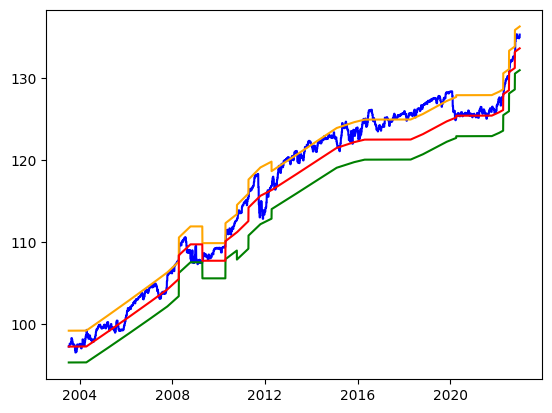

In [178]:
plt.plot(policy_df.index, policy_df['real'], color='blue')
plt.plot(policy_df.index, policy_df['up'], color='orange')
plt.plot(policy_df.index, policy_df['down'], color='green')
plt.plot(policy_df.index, policy_df['mid'], color='red')

plt.show()

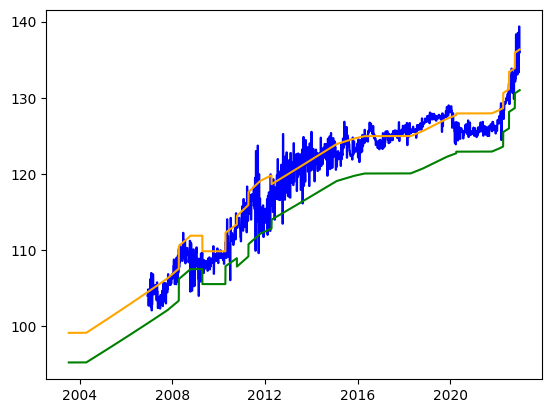

In [183]:
plt.plot(policy_df.index, policy_df['pred'], color='blue')
plt.plot(policy_df.index, policy_df['up'], color='orange')
plt.plot(policy_df.index, policy_df['down'], color='green')

plt.show()

In [186]:
policy_df ["is_up"] = policy_df ["pred"] >= policy_df ["mid"]
distance_up = policy_df ["up"] - policy_df ["pred"]
distance_dn = policy_df ["pred"] - policy_df ["down"]
distance = np . where ( policy_df ["is_up"] , distance_up , distance_dn )
policy_df ["distance"] = distance
policy_df ["dist_score"] = distance / ( policy_df ["up"] - policy_df ["down"])
model_df =policy_df.dropna()

In [188]:
weights_df = pd . DataFrame ( weights ) . transpose ()
df = pd . DataFrame ( index = daily_range )
df.index=df.index.date
modelled_index = model_df.index
model_df = df . join ( model_df ) . fillna ( method ="ffill")
modelled_idx = model_df . dropna () . index
model_df = model_df . fillna ( method ="bfill")
weights_df = df . join ( weights_df ) . fillna ( method ="ffill") . fillna ( method ="bfill")

model_df ["directional_sgd"] = np . where (~ model_df ["is_up"] , 1 , -1) # note ~ means !=
model_df ["directional_sgd"] = np . where ( model_df ["dist_score"] > 0.05 , 0 , model_df ["directional_sgd"])

In [189]:
model_df

,mid,halfband,slope,up,down,real,pred,is_up,distance,dist_score,directional_sgd
1999-01-08,102.435580,0.02,0.020000,104.484291,100.386868,104.01,104.018991,True,0.465301,0.113559,0
1999-01-09,102.435580,0.02,0.020000,104.484291,100.386868,104.01,104.018991,True,0.465301,0.113559,0
1999-01-10,102.435580,0.02,0.020000,104.484291,100.386868,104.01,104.018991,True,0.465301,0.113559,0
1999-01-11,102.435580,0.02,0.020000,104.484291,100.386868,104.01,104.018991,True,0.465301,0.113559,0
1999-01-12,102.435580,0.02,0.020000,104.484291,100.386868,104.01,104.018991,True,0.465301,0.113559,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,133.658150,0.02,0.015625,136.331313,130.984987,135.05,135.971156,True,0.360158,0.067365,0
2022-12-27,133.663828,0.02,0.015625,136.337104,130.990551,135.05,135.971156,True,0.365949,0.068446,0
2022-12-28,133.669506,0.02,0.015625,136.342896,130.996116,135.05,135.971156,True,0.371740,0.069526,0
2022-12-29,133.675184,0.02,0.015625,136.348687,131.001680,135.05,135.971156,True,0.377532,0.070606,0
